# [SF-DST] Car Price prediction Part2

This work has made by Paul Krivchenia:

[My GitHub](https://github.com/Paull-dark)

<img src = 'https://s.auto.drom.ru/i24222/pubs/4483/61605/2852355.jpg' width= '800px'>

The Target of this project is to:
- To make a exploratory data analysis
- Creating conventional ML models
- Building a natural language processing model.
- Building CV models
- Stacking models
- Predict the price of auto by its parameters

<a id="sec1"></a>
# 1 [Features Defination](sec1)

**BodyType** -  The type of the Body of car .

**Brand** - Name of brand.

**color** - Color of the car (hex).

**description** - human's description of the car (given by seller).

**engineDisplacement** - Working volume of the engine (in $mm^3$).

**enginePower** - Power in Horses.

**fuelType** - Diesel, gasoline electric etc.

**mileage** - How many kilometers car passed up to the date.

**modelDate** - When particular model has been designed.

**model_info** - Model info. Categorical.

**name** - Categorical.

**numberOfDoors** - The number of doors in a single car.

**PriceCurrency** - The currency of the car's price.

**productionDate** - The date when the car has been released from factory.

**sell_id** - id of image.

**vehicleConfiguration** - shows body type, type of gear, volume of engine.

**vehicleTransmission** - Gear type.

**Владельцы** - How many owners had particular car before.

**Владение** - How long the seller own a particular car.

**ПТС** - Shows whether the car's documents in original state.

**Привод** - Wheel drive (2WF,4WD etc).

**Руль** - Left or right Wheel.

**price** - price in RUB (TARGET).

<a id="sec2"></a>
# [INDEX](#sec2)

<a id="sec1"></a>
1. [Description](#sec1)
   * [1.1 Features Defination](#sec1.1)
2. [INDEX](#sec2)
3. [IMPORT LIBRARRIES](#sec3)
4. [Functions and Classes](#sec4)
5. [Load and Chek the Dataset](#sec5)
   * [5.1 Load train and test sets](#sec5.1)
   * [5.2 Pre-processing before stacking data sets](#sec5.2)
   * [5.3 Missing Values](#sec5.3)
   * [5.3 Pandas Profiling](#sec5.3)
6. [Data Analyse](#sec6)
     * [6.1 Target Variable](#sec6.1)
     * [6.2 Categorical Columns analysis](#sec6.2)
        * [6.2.1 Body_type - price - owners count](#sec6.2.1)
        * [6.2.2 Model_name](#sec6.2.2)
        * [6.2.3 Vehicle_transmission - price](#sec6.2.3)
        * [6.2.4 Color - price](#sec6.2.4)
        * [6.2.5 Body_type - price - wheel-drive](#sec6.2.5)
        * [6.2.6 Wheel_location](#sec6.2.6)
     * [6.3 Combination of Categorical and Numeric columns](#sec6.3)
     * [6.4 Numeric columns](#sec6.4)
     * [6.5 Correlation matrices](#sec6.5)
     * [6.6 Sentiment Analyse](#sec6.6)
     * [6.7 Draw a Conclusion](#sec6.7)

<a id="sec3"></a>
# [3 Import LIBRARIES](#sec3)

In [1]:
import os
import pandas as pd
import numpy as np
import re
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import warnings
import PIL
import cv2

from textblob import TextBlob  # for sentiment analysis
from wordcloud import WordCloud #STOPWORDS # for creating cloud of words
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA

from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm  as lgb
import lightgbm
import optuna

# # keras
import tensorflow as tf
#import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.losses import mean_absolute_percentage_error
from tensorflow.math import expm1
from tqdm.notebook import tqdm

import albumentations

from nltk.corpus import stopwords
from pymystem3 import Mystem

In [2]:
warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_rows', 50)  # Show more rows
pd.set_option('display.max_columns', 50)  # Show more columns
plt.style.use('ggplot')  # Nice plotting

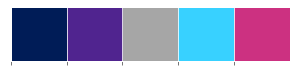

In [3]:
# Set project colors
colors = ['#001c57', '#50248f', '#a6a6a6', '#38d1ff','#cc3181']
sns.palplot(sns.color_palette(colors))

<a id="sec4"></a>
# [4 FUNCTIONS and CLASSES](#sec4)
[(INDEX)](#sec2)

<a id="sec4.1"></a>
## [4.1 GENERAL FUNCTIONS and CLASSES](#sec4.1)
[(INDEX)](#sec2)

In [4]:
def pandas_report(data, title, minimal=True):
    ''' Function is called for generating of dataset profile-report'''

    profile = data.profile_report(title=title,
                                  progress_bar=False,
                                  minimal=minimal,
                                  correlations={
                                      'pearson': {
                                          'calculate': True
                                      },
                                      'spearman': {
                                          'calculate': True
                                      },
                                      'kendall': {
                                          'calculate': False
                                      },
                                      'phi_k': {
                                          'calculate': False
                                      },
                                      'cramers': {
                                          'calculate': False
                                      }
                                  },
                                  interactions={
                                      'continuous': True,
                                      'targets': []
                                  },
                                  missing_diagrams={
                                      'heatmap': True,
                                      'dendrogram': False,
                                      'matrix': True
                                  },
                                  vars={'cat': {
                                      'n_obs': 10
                                  }})

    return profile

In [5]:
def get_boxplot(data,
                X_axis,
                Y_axis,
                hue=None,
                figsize=(7, 5),
                take_less_box=False):
    '''Function is called to plot boxplots
    ------
    data - pandas dataframe
    X_axis - column need to be reflected in X axis
    Y_axis - column need to be reflected in X axis
    take_less_box - Default is False. If need to plot only 7 boxes
    '''
    if take_less_box:
        fig, ax = plt.subplots(figsize=figsize)
        sns.boxplot(x=X_axis,
                    y=Y_axis,
                    hue=hue,
                    data=data.loc[data.loc[:, X_axis].isin(
                        data.loc[:, X_axis].value_counts().index[:7])],
                    palette=colors)
        plt.xticks(rotation=45)
        ax.set_title(f'Boxplot for {X_axis} and {Y_axis}', fontsize=14)
        plt.show()

    else:
        fig, ax = plt.subplots(figsize=figsize)
        sns.boxplot(x=X_axis, y=Y_axis, hue=hue, data=data, palette=colors)
        plt.xticks(rotation=45)
        ax.set_title(f'Boxplot for {X_axis} and {Y_axis}', fontsize=14)
        plt.show()

In [6]:
def get_scatter_plot(data, X_axis, Y_axis, title=None, width=600, height=500):

    title = title if title is not None else f"Scatterplot for {X_axis} VS {Y_axis}"
    fig = px.scatter(data, x=X_axis, y=Y_axis, size=Y_axis)
    # Edit the layout
    fig.update_layout(title=title)
    fig.update_xaxes(title=(f'{X_axis}'))
    fig.update_yaxes(title=(f'{Y_axis}'))
    fig.update_layout(width=width)
    fig.update_layout(height=height)
    fig.show()

In [7]:
def get_variable_distribution(col, title=None):
    '''Function is called to plot feture distribution'''

    title = title if title is not None else f"Distribution for '{col}"
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5),)
    fig = sm.qqplot(col, fit=True, line='45', ax=ax1)
    fig.suptitle(title, fontsize=20)

    sns.distplot(col.values, bins=20, color=colors[1], ax=ax2)
#     sns.violinplot(col.values, color=colors[3], bw=.3, cut=1, linewidth=4)
    sns.boxplot(col.values,color=colors[3])

    ax1.set_title('QQ-plot')
    ax2.set_title('Distribution')
    ax3.set_title('Boxplot')

    plt.show()

In [8]:
def corr_matrix(data, det=True, pltx=10, plty=10):
    '''Funcion is called for making a correlation matrix'''

    corr = data.corr()
    if det:

        evals, evec = np.linalg.eig(corr)
        ev_product = np.prod(evals)

        print(f'Rank of Matrix: {np.linalg.matrix_rank(corr)}')
        print(f'Determinant of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(corr)}')

    plt.figure(figsize=(pltx, plty))
    sns.heatmap(corr[(corr >= .2) | (corr <= -.2)],
                cmap='viridis',
                vmin=-1.0,
                linewidths=0.1,
                annot=True,
                annot_kws={"size": 10},
                square=True)
    #     sns.heatmap(X,vmin=0,vmax=.9,annot=True,square=True)
    plt.show()

In [9]:
def missing_vars(data, column, random_proba=True):
    '''Function is called for filling of missing data'''
    # With using probability and random choise

    if random_proba:
        col_name = data[column].value_counts().index.to_list(
        )  # get list of values
        col_distr = data[column].value_counts(
            normalize=True).values  # get l;ist of probs
        missing = data[col].isnull()  # flag of missing val
        # substitute values from the list of names in accordance with the probability of meeting the name
        data.loc[missing, [column]] = np.random.choice(col_name,
                                                       size=len(data[missing]),
                                                       p=col_distr)

    # Using  most common in  column
    data[col] = data[col].fillna(data[col].value_counts().index[0])

In [10]:
class Outliers_detector():
    def __init__(self, df):
        self.df = df

    def get_IQR_outliers(self, column):
        '''Method is called to detect IQR outliers'''
        outliers = dict()
        q1, q3 = np.percentile(sorted(self.df[column]), [25, 75])

        IQR = q3 - q1

        l_b = q1 - (1.5 * IQR)  # lower bound
        u_b = q3 + (1.5 * IQR)  # upper bound
        outl_count = len(self.df[column][self.df[column] < l_b]) + len(
            self.df[column][self.df[column] > u_b])

        outliers['lower_bound'] = round(l_b, 3)
        outliers['upper_bound'] = round(u_b, 3)
        outliers['outlier_count'] = outl_count

        return outliers

    def get_dbscan_outliers(self, column1, column2, dbscan_eps,
                            dbscan_minsample, cluster_num):
        '''Method is called for detecting outliers for two columns by dbscan'''

        scaler = RobustScaler()
        scale_column1 = scaler.fit_transform(pd.DataFrame(
            self.df[column1])).reshape(1, -1)[0]
        scale_column2 = scaler.fit_transform(pd.DataFrame(
            self.df[column2])).reshape(1, -1)[0]
        df_temp = pd.DataFrame({
            'column1': scale_column1,
            'column2': scale_column2
        })
        clustering = DBSCAN(eps=dbscan_eps,
                            min_samples=dbscan_minsample).fit(df_temp.values)
        df_temp["cluster"] = clustering.labels_
        df_temp.index = self.df.index
        fig = px.scatter(self.df,
                         x=scale_column1,
                         y=scale_column2,
                         color=clustering.labels_,
                         size=column2)
        # Edit the layout
        fig.update_layout(title='Detected Custers\n')
        fig.update_xaxes(title=(f'{column1}'))
        fig.update_yaxes(title=(f'{column2}'))
        fig.update_layout(width=700)
        fig.update_layout(height=600)
        fig.show()

        return df_temp[df_temp["cluster"] == cluster_num].index

    def get_dbscan_outliers3D(self, column1, column2, column3, dbscan_eps,
                              dbscan_minsample, cluster_num):
        '''Method is called for detecting outliers for two columns by dbscan in 3D axis'''

        scaler = RobustScaler()
        scale_column1 = scaler.fit_transform(pd.DataFrame(
            self.df[column1])).reshape(1, -1)[0]
        scale_column2 = scaler.fit_transform(pd.DataFrame(
            self.df[column2])).reshape(1, -1)[0]
        scale_column3 = scaler.fit_transform(pd.DataFrame(
            self.df[column3])).reshape(1, -1)[0]
        df_temp = pd.DataFrame({
            'column1': scale_column1,
            'column2': scale_column2,
            'column3': scale_column3
        })
        clustering = DBSCAN(eps=dbscan_eps,
                            min_samples=dbscan_minsample).fit(df_temp.values)
        df_temp["cluster"] = clustering.labels_
        df_temp.index = self.df.index
        fig = px.scatter_3d(self.df,
                            x=scale_column1,
                            y=scale_column2,
                            z=scale_column3,
                            color=clustering.labels_,
                            size=column3)
        # Edit the layout
        fig.update_layout(title='Detected Custers\n')

        fig.update_layout(scene = dict(
                    xaxis_title=(f'{column1}'),
                    yaxis_title=(f'{column2}'),
                    zaxis_title=(f'{column3}')),
                    width=700,
                    margin=dict(r=40, b=30, l=30, t=30)
                         )

#         fig.update_layout(width=700)
#         fig.update_layout(height=600)
        fig.show()

        return df_temp[df_temp["cluster"] == cluster_num].index

In [11]:
class String_cleaner():
    
    # keep numbers and letters in a string
    def letnum_filter(self,string):
        f = filter(str.isalnum, string)
        s1 = ''.join(f)
        return s1
    
    # keep numbers in a string
    def num_filter(self,string):
        f = filter(str.isnumeric, string)
        s2 = ''.join(f)
        return s2  
    
    # Keep letters in a string
    def letter_filter(self,string):
        f = filter(str.isalpha, string)
        s3 = ''.join(f)
        return s3
    
    # removing spaces
    def remove_space(self,string):
        s4 = str(string)
        s4 = s4.strip()
        s4 = re.sub(r'(\d)\s+(\d)', r'\1\2', s4)
        return s4

In [12]:
def cleanTxt(text):
    '''Function is called for cleaning text from trash
    INPUT: dirty string
    OUTPUT: More or less clean string'''

    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+",
        flags=re.UNICODE)

    text = re.sub(r'@[А-Яа-я0-9]+', '', text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove @
    text = re.sub(r'#', '', text)  # remove #
    text = re.sub(r'{', '', text)
    text = re.sub(r'}', '', text)
    text = re.sub("[.|/|-|\|,|!]", '', text)  # ~~~~~~~~~~~
    text = re.sub(r'^а-яА-Я', '', text)
    text = re.sub('^a-zA-Z', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)  # remove hyperlink
    text = re.sub(r'\n', '', text)
    text = emoji_pattern.sub(r'', text)

    text = text.strip()
    text = text.lower()

    #text = text.split()
    return text

In [13]:
class Encoder:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def label_encoder(self, column):
        '''Method for label encoding'''
        le = LabelEncoder()
        self.dataframe[column] = le.fit_transform(self.dataframe[column])

    def hot_encoder(self, column):
        '''Method for hot encoding'''
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        aux_df = pd.DataFrame(ohe.fit_transform(self.dataframe[[column]]))
        aux_df.columns = ohe.get_feature_names([f'hot_{column}'])
        self.dataframe = self.dataframe.drop(col, axis=1)
        self.dataframe = pd.concat([self.dataframe, aux_df], axis=1)
        return self.dataframe

In [14]:
def to_log(df, cols_to_log):
    'smart log'
    for col in cols_to_log:
        a = df[col].min()
        if a <= 0:                        
            df[col] = np.log(df[col] + (int(abs(df[col].min()))+2))
        
        df[col] = np.log(df[col])
    return df

<a id="sec4.2"></a>
## [4.2 Specific Functions](#sec4.2)
[(INDEX)](#sec2)

In [15]:
# Defining MAPE function since it was removed from sklearn
def mape(y_true, y_pred):
    'Function to calculate MAPE metric'
#     y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [16]:
def get_regression_metrics(report_df,y_true, y_pred, name, exp = True):
    '''Create and add metrics into a pandas DF after experiment'''
    if exp: 
        y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)

    report = pd.DataFrame(columns={'MAPE'}, data=[0])
    try:
        report['MAPE'] = mape(y_true, y_pred)
    except:
        report['MAPE'] = 'failed'
    try:
        report['MAE'] = mean_absolute_error(y_true, y_pred)
    except:
        report['MAE'] = 'None'
    try:
        report['MSE'] = mean_squared_error(y_true, y_pred)
    except:
        report['MSE'] = 'None'
    try:
        report['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
    except:
        report['RMSE'] = 'None'

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

<a id="sec4.3"></a>
## [4.3 FUNCTIONS FOR FEATURE ENGINEERING](#sec4.3)
[(INDEX)](#sec2)

In [17]:
def get_low_registr(word):
    '''Get lowercase for string'''
    try:
        return word.lower()
    except:
        return None

<a id="sec5"></a>
# [5.Load and Chek the Dataset](#sec5)
[(INDEX)](#sec2)

In [18]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [19]:
df_test.info()
df_test.sample(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

bodyType     brand   color  \
1242  минивэн  MERCEDES  чёрный   

                                            description engineDisplacement  \
1242  Допопция: боковые электродвери с дистанционным...            2.1 LTR   

     enginePower fuelType  mileage  modelDate model_info  \
1242     136 N12   дизель    45000       2010      VIANO   

                       name  numberOfDoors  productionDate     sell_id  \
1242  L1 2.1d AT (136 л.с.)              4            2012  1071187919   

       vehicleConfiguration vehicleTransmission   Владельцы Владение  \
1242  MINIVAN AUTOMATIC 2.1      автоматическая  1 владелец      NaN   

           ПТС  Привод   Руль  
1242  Оригинал  задний  Левый

In [20]:
df_train.info()
df_train.sample(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

bodyType brand   color  \
375  внедорожник 5 дв.   BMW  чёрный   

                                           description engineDisplacement  \
375  Отличное состояние, продаю в связи с переездом...            3.0 LTR   

    enginePower fuelType  mileage  modelDate model_info  \
375     235 N12   дизель   240000       2006         X5   

                            name  numberOfDoors     price  productionDate  \
375  3.0d 3.0d AT (235 л.с.) 4WD              5  920000.0            2008   

        sell_id           vehicleConfiguration vehicleTransmission  \
375  1094523142  ALLROAD_5_DOORS AUTOMATIC 3.0      автоматическая   

       Владельцы            Владение       ПТС  Привод   Руль  
375  3 или более  1 год и 10 месяцев  Оригинал  полный  Левый

In [21]:
print(
    f'Shape of Train Dataset:{df_train.shape}\nShape of Test Dataset:{df_test.shape} \n'
)

Shape of Train Dataset:(6682, 22)
Shape of Test Dataset:(1671, 21) 



<a id="sec6"></a>
# [6 BASELINE MODEL](#sec6)
[(INDEX)](#sec2)

In [22]:
# split данных
data_train, data_test = train_test_split(df_train,
                                         test_size=0.15,
                                         shuffle=True,
                                         random_state=42)

In [23]:
print(f'Train size: {data_train.shape}, Validation size: {data_test.shape}')

Train size: (5679, 22), Validation size: (1003, 22)


In [24]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info',
                                          'productionDate']]).iterrows():
#     query = f"model_info == '{row[0]}' and productionDate == '{(row[1])}'"
#     predicts.append(data_train.query(query)['price'].median())
    predicts.append(data_train[(data_train['model_info'] == row[0])
                               & (data_train['productionDate'] == row[1])]['price'].median())

In [25]:
# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())
# округлим
predicts = (predicts // 1000) * 1000

Check the accuracy of the model

In [26]:
# create empty df
df_report = pd.DataFrame(data=None)

In [27]:
# Run func to get regression metrics
df_report = get_regression_metrics(df_report, data_test['price'],
                                   predicts[0].values, 'BaseLine',exp = False)
df_report

MAPE           MAE           MSE           RMSE
BaseLine  19.877351  347328.24327  8.691772e+11  932296.757864

<a id="sec7"></a>
# [7 Pre-processing before stacking data sets](#sec7)
[(INDEX)](#sec2)

Rename columns removing spaces and substituting capital letters

In [28]:
columns = {
    'bodyType': 'body_type',
    'engineDisplacement': 'engine_displacement',
    'enginePower': 'engine_power',
    'fuelType': 'fuel_type',
    'modelDate': 'model_date',
    'numberOfDoors': 'doors_count',
    'productionDate': 'production_date',
    'vehicleConfiguration': 'vehicle_configuration',
    'vehicleTransmission': 'vehicle_transmission',
    'Владельцы': 'owner_count',
    'Владение': 'owning_period',
    'ПТС': 'car_passport',
    'Привод': 'wheel_drive',
    'Руль': 'wheel_location',
}

In [29]:
df_test.rename(columns=columns,inplace=True)
df_train.rename(columns=columns,inplace=True)

Keep only float numbers in **[engine_displacement column]**.

In [30]:
# clear 'LTR in test set'
df_test['engine_displacement'] = df_test['engine_displacement'].apply(
    lambda x: str(x).replace('LTR', ''))
# convert object to float in test set
df_test['engine_displacement'] = df_test['engine_displacement'].apply(
    lambda x: np.nan if x.strip() == 'undefined' else float(x))

Do the same for train set

In [31]:
# clear 'LTR in test set'
df_train['engine_displacement'] = df_train['engine_displacement'].apply(
    lambda x: str(x).replace('LTR', ''))
# convert object to float in test set
df_train['engine_displacement'] = df_train['engine_displacement'].apply(
    lambda x: np.nan if x.strip() == 'undefined' else float(x))

**[enginePower column]**

In [32]:
# clear 'N12 in test set'
df_test['engine_power'] = df_test['engine_power'].apply(
    lambda x: str(x).replace('N12', ''))

# convert object to float in test set
df_test['engine_power'] = df_test['engine_power'].apply(
    lambda x: np.nan if x.strip() == '' else float(x))

Same for train set

In [33]:
# clear 'N12 in test set'
df_train['engine_power'] = df_train['engine_power'].apply(
    lambda x: str(x).replace('N12', ''))

# convert object to float in test set
df_train['engine_power'] = df_train['engine_power'].apply(
    lambda x: np.nan if x.strip() == '' else float(x))

<a id="sec5.1"></a>
# [7.1 Stacking data sets](#sec5.2)
[(INDEX)](#sec2)

For further feature engineering, let's combine two datasets into a one

In [34]:
# let's mark where is train where is test set.
df_train['sample'] = 1  # train
df_test['sample'] = 0  # test

In [35]:
df = df_train.append(df_test, sort=False).reset_index(
    drop=True)  # combine sets

<a id="sec7.2"></a>
## [7.2 Missing Values](#sec7.2)
[(INDEX)](#sec2)

body_type - 0.0%
brand - 0.0%
color - 0.0%
description - 0.0%
engine_displacement - 0.072%
engine_power - 0.0%
fuel_type - 0.0%
mileage - 0.0%
model_date - 0.0%
model_info - 0.0%
name - 0.0%
doors_count - 0.0%
price - 20.005%
production_date - 0.0%
sell_id - 0.0%
vehicle_configuration - 0.0%
vehicle_transmission - 0.0%
owner_count - 0.012%
owning_period - 64.863%
car_passport - 0.0%
wheel_drive - 0.0%
wheel_location - 0.0%
sample - 0.0%


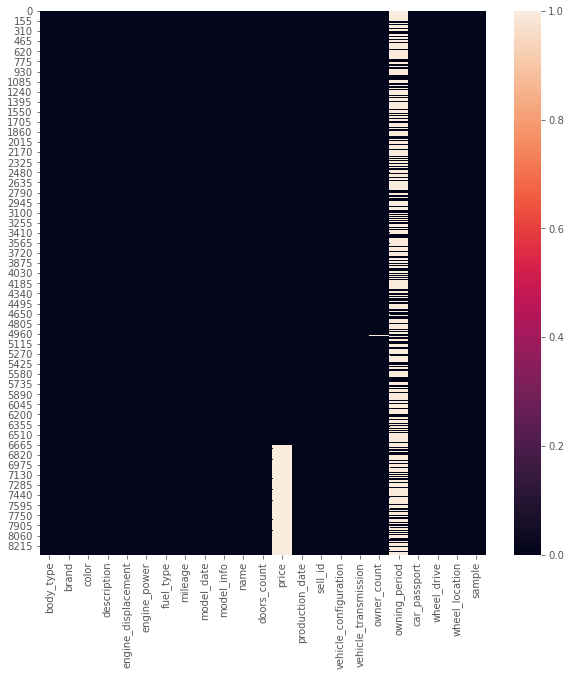

In [36]:
# Plot missing values
cols = df.columns
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df[cols].isnull()) 

# Show in percents
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print(f'{col} - {round(pct_missing*100,3)}%')

engine_displacement has some missing cells. 

Price has missing cells but it is ok, because our test set appended here in combined set

Owning Period has shitload of missing vars :(

<a id="sec7.3"></a>
## [7.3 Pandas Profiling](#sec7.3)
[(INDEX)](#sec2)

In [37]:
%%script False
# We won't include some colums in the report
cols_exclude = [
    'sample', 'name', 'owning_period', 'sell_id',
    'vehicle_configuration'
]

data_profile = pandas_report(df_train.drop(cols_exclude, axis=1),
                             'car_price_prediction')
# Check your folder
data_profile.to_file('pandas_report.html')

Couldn't find program: 'False'


Link for the  **[the dataset profile report](./pandas_report.html)**.

 - Dataset has 23 features (excluding feature 'Sample')
 
 - Total Number Of observations is 6682
 
 - Missing values is about 0.1% 
 
 - There are no potential duplicates
 
 
 - ***body_type*** 0.3% of unique entities. We need to process this column in the future sections. 
 
 - ***brand*** we have 3 brand of cars.
 
 - ***color*** Consists 16 distinct categories: 
     
  - Чёрный (42%)
 
  - Белый (18 %)
 
  - Серый (11%)
 
  - other colors
 
 - ***description*** - has 92% distinct descriptions. This means some of the information is repeating. It can say us that there are some sale announcements from agency seller rs (perekup).
 
 - ***engine_displacement*** - the overwhelming majority of engines has a volume of 2 and 3 liters. This information could be converted to a categorical one with the sorting of engines like <span style="color:red">low volume, middle, high engine volume.</span>
  - mean - 2.78 l;
 
  - median - 2.;
 
  - Q1 - 2 l;
 
  - Q3 - 3 l;
 
  - maximum - 6.6 (insane :))
 
  - minimum - 0.7
 
 - ***engine_power*** - most common power is 184 h.p. Second place takes engine with power 249 h.p.
 
  - mean - 255;
  
  - median - 231;
 
  - Q1 - 184;
 
  - Q3 - 306;
 
  - maximum - 639;
 
  - minimum - 75
 
 - ***fuel_type*** - Of course, the first place takes Gasoline (бензин). Seems nothing interesting here.
 
 - ***mileage*** - We have distribution biased to left with a huge amount of cars with zero mileage (probably new cars). That is also good feature <span style="color:red">insight</span> . Need to separate new cars from used.
 
 - ***model_date** - *Distribution with right tail. Most of models presented in dataset designed in 21st Century
 
  - mean - 2010;
  
  - median - 2011;
 
  - Q1 - 2007;
 
  - Q3 - 2014;
 
  - maximum - 2019;
 
  - minimum - 1975
  
 - ***model_info*** - HIGH CARDINALITY categorical variable
 
 - ***doors_count*** - Overwhelming majority of cars in dataset has 5 an 4 doors.
 
 - ***production_date*** - We have distribution biased to right. Most of cars in our dataset quite fresh. It must impact on the price.
 
 
 - ***vehicle_transmission*** - It is a categorical feature. Most of types are *automatic*. 
  
 - ***owner_count*** -  Has 1 missing cell . Category 3 or more owners  takes first place in the distribution. Then one owner
 
 -***car_passport*** 89% has original passport
 
 -***wheel_drive***  63% has 4WD.
 
 -***wheel_location*** - 99% has left location of wheel
  
 -***price*** - is a target variable. Detailed analysis will be performed later.
 
 
Need to be noted that we have some strong correlations such as production year correlated with a mileage, engine power and price etc.. 
 

<a id="sec8"></a>
# [8.Data Analysis](#sec8)
[(INDEX)](#sec2)

<a id="sec8.1"></a>
## [8.1 Target Variable](#sec8.1)
[(INDEX)](#sec2)

count    6.682000e+03
mean     1.899868e+06
std      1.914153e+06
min      3.013010e+05
25%      8.000000e+05
50%      1.300000e+06
75%      2.299283e+06
max      2.390000e+07
Name: price, dtype: float64

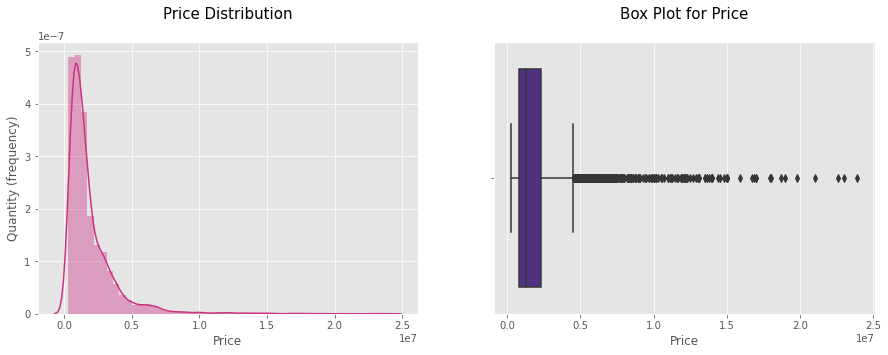

In [38]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(df_train.price.values, bins=50, color=colors[4])
plt.title('Price Distribution\n', fontsize=15)
plt.xlabel('Price')
plt.ylabel('Quantity (frequency)');

plt.subplot(122)
sns.boxplot(df_train.price.values, color=colors[1])
plt.title('Box Plot for Price\n', fontsize=15)
plt.xlabel('Price');

df_train['price'].describe()

The Target variable has a biased distribution shifted to the left side of 0 to 24 millions. 

The first and third quartiles are in the range from 800k to 2.2 million, the mean is 1.9 million. Also outliers has been observed for target variable.

<a id="sec8.2"></a>
## [8.2 Categorical Columns analysis](#sec8.2)
[(INDEX)](#sec2)

<a id="sec8.2"></a>
## [8.2 Categorical Columns analysis](#sec8.2)
[(INDEX)](#sec2)

Check out how many body types in total we have

In [39]:
print(f'Total Number of body types in DataSet: {df_train.body_type.nunique()}')

Total Number of body types in DataSet: 17


In [40]:
df_train.body_type.value_counts()

седан                   2843
внедорожник 5 дв.       2315
купе                     427
хэтчбек 5 дв.            296
лифтбек                  245
универсал 5 дв.          153
минивэн                  146
купе-хардтоп              91
родстер                   60
кабриолет                 44
хэтчбек 3 дв.             41
компактвэн                 8
лимузин                    5
внедорожник 3 дв.          3
пикап двойная кабина       2
внедорожник открытый       2
седан 2 дв.                1
Name: body_type, dtype: int64

It's quite a lot. Moreover, it is mentioned here the number of doors. Let's reduce quantity by extracting the key meaning.

In [41]:
pattern = re.compile('[а-я]*')
new_column = []
for string in df_train['body_type']:
    new_column.append(pattern.match(str(string))[0])
df_train['body_type'] = new_column

In [42]:
print(f'Total Number of body types in DataSet: {df_train.body_type.nunique()}')

Total Number of body types in DataSet: 12


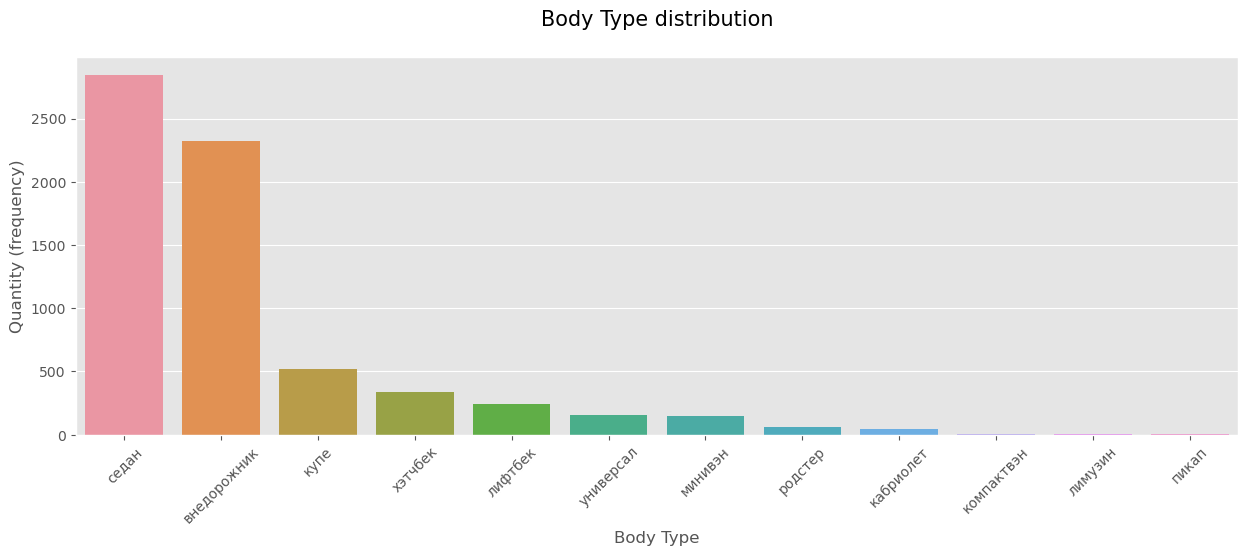

In [43]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(df_train['body_type'], order=df_train['body_type'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Body Type distribution\n', fontsize=15)
plt.xlabel('Body Type')
plt.ylabel('Quantity (frequency)');

The most popular body type is 'седан'  , then 'внедорожник'.

Let's see how it is impact on price. In addition, let's see whether the number of owners impact on price

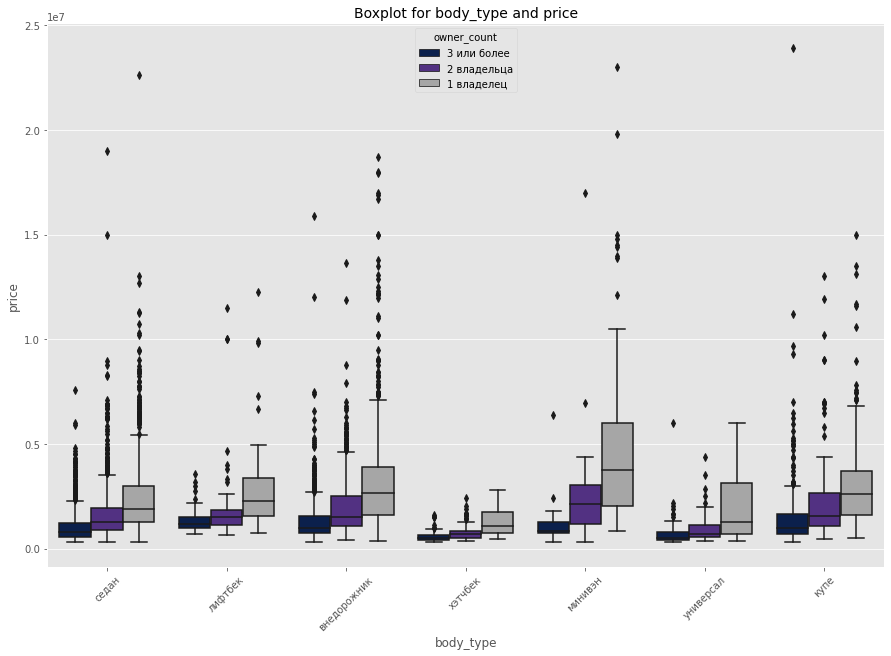

In [44]:
get_boxplot(df_train, 'body_type', 'price', figsize=(
    15, 10), hue='owner_count', take_less_box=True)

We can see that quantity of owners impacts on the final price. if car has lots of owners , then less final price. Also, body type itself impact on price car. Minivan in average more expensive than others.

Or maybe it is depend on age of car? More older car has more owners? We will check bellow.


<a id="sec8.2.2"></a>
### [8.2.2 Color - price](#sec8.2.2)
[(INDEX)](#sec2)

Let's check how color impact on price

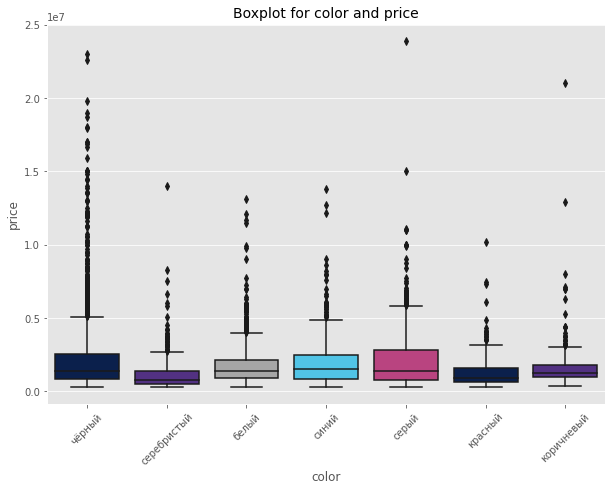

In [45]:
get_boxplot(df_train, 'color', 'price', figsize=(10, 7), take_less_box=True)

Seems there is no impact.

<a id="sec8.2.3"></a>
### [8.2.3 Body_type - price - wheel-drive](#sec8.2.3)
[(INDEX)](#sec2)

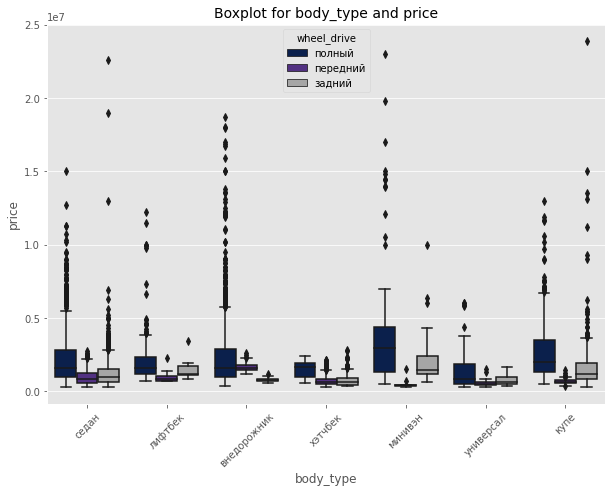

In [46]:
get_boxplot(df_train,
            'body_type',
            'price',
            hue='wheel_drive',
            figsize=(10, 7),
            take_less_box=True)

Well, we may see there is more cars with 4WD for each body type and this is most expensive category.

<a id="sec8.2.4"></a>
### [8.2.4 Wheel-location](#sec8.2.4)
[(INDEX)](#sec2)

In [47]:
fig = px.scatter_3d(df_train,x='brand',y='wheel_location',z='price',
                   color='price')
fig.show()

Overwhelming majority of cars are left-wheeled.

Let's check the fuel type by brands and how it is impact on price

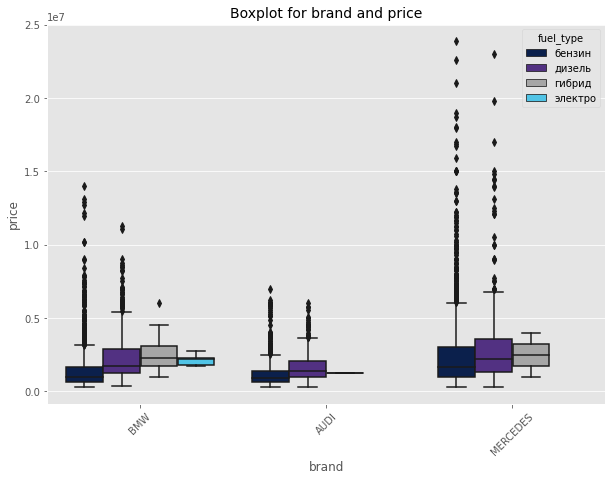

In [48]:
get_boxplot(df_train,'brand','price',hue = 'fuel_type',figsize=(10, 7))

Our data set has more cars from Mercedes. Conventional fuel type is more cheaper than electro or hybrid

<a id="sec8.3"></a>
## [8.3 Combination of Categorical and Numeric columns](#sec8.3)
[(INDEX)](#sec2)

What about power? What car more powerfull?

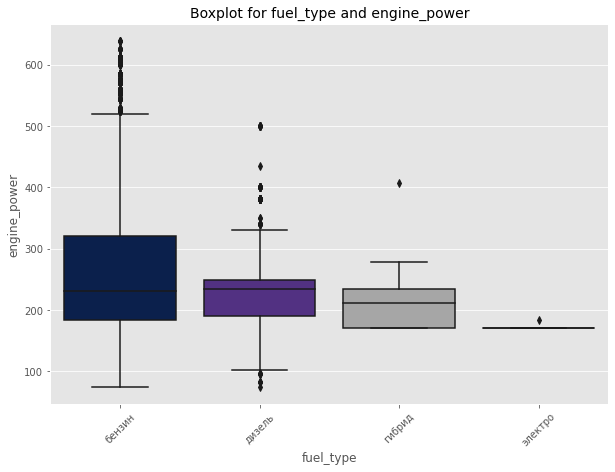

In [49]:
get_boxplot(df_train, 'fuel_type', 'engine_power', figsize=(10, 7))

We have a displacement of engine. Let's check how displacement affects power.

We see that the median value of a diesel cars is slightly higher than gaasoline cars.

In [50]:
get_scatter_plot(df_train, 'engine_displacement', 'engine_power')

Quite predictable. Bigger displacement, more power we have. But here we have couple of notes.

There are couple strange cars with huge displacement but low power.

Let's check the age of car and quantity of owners

In [51]:
# generate age of car
df_train['car_age'] = 2021 - df_train['production_date']

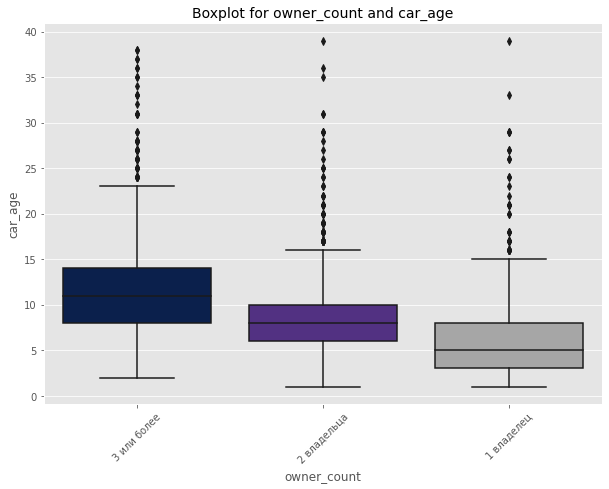

In [52]:
get_boxplot(df_train, 'owner_count', 'car_age', figsize=(10, 7))

Old car had more owners. As we mentioned before, it may impact on price. Probably we need to take only one feature for the model. Owner count or production year.

Eventually, let's see milleage, price and year of production

In [53]:
fig = px.scatter_3d(df_train, x='mileage', y='production_date',
                    z='price', color='price')
# Edit the layout
fig.update_layout(title='Price-Mileage-Production date')
fig.update_layout(width=600)
fig.update_layout(height=600)
fig.show()

In general the production date and milage negativelly impact on a price. 

More older car with hige mileage has lower price. But we also have exceptions. 

Some old cars has extreamly high price (ned to note that their mileage not so high).

How does this car become cheaper with age?

Let's take all years for the performing analysis of dropping the price

In [54]:
# More older cars might be more expensive
df_aux = df_train.groupby(['production_date','brand'])['price'].mean().reset_index()

In [55]:
fig = px.line(df_aux,
              x='production_date',
              y='price',
              color='brand',
              line_group='brand',
              hover_name='brand')
# Edit the layout
fig.update_layout(title='Average price change by years',
                  xaxis_title='Production Year',
                  yaxis_title='Price in RUB')
fig.update_layout(width=800)
fig.update_layout(height=600)
fig.show()

Interesting picture. The average price is dropping first, and then start to growth. It can be explained that old cars become more and more expensive with time flow.

Also, the price changes not linear but with some bended curve (simillar with a parabola)

We can see that some brands price drop their price by time flow more rapidly and more stronger than others.

In [56]:
def get_price_change(df, brand_list):
    '''Function is called to get mean change 
    of price by years for dedicated car model'''
    # create dataframe
    df_avg_prc = pd.DataFrame(data=None,
                              columns=['brand', 'avg_price_change'],
                              index=range(len(brand_list)))
    for i, brand in enumerate(brand_list):
        # write down the brand name in DF
        df_avg_prc.loc[i]['brand'] = brand
        # extract from inserted dataframe particular car brand and its price
        mean_price = df[df['brand'] == f'{brand}']['price']
        # Compute change of price by years and take mean from all changes in percnts
        df_avg_prc.loc[i]['avg_price_change'] = 100 * \
            (mean_price.pct_change().mean())
    return df_avg_prc

In [57]:
# Take brands
brands = list(df_aux['brand'].unique())
prcnt_chng_df = get_price_change(df_aux,brands)
prcnt_chng_df.sample(3)

brand avg_price_change
1  MERCEDES        25.108294
0       BMW          20.9876
2      AUDI        13.041846

In [58]:
fig = px.scatter(prcnt_chng_df,x=brands,y='avg_price_change')
fig.update_layout(title='Price change in percents',
                  xaxis_title='Model',
                  yaxis_title='Price change in Percents')
fig.update_layout(width=600)
fig.update_layout(height=400)
fig.show()

As a conclusion, we see that for all cars price rapidly drops in the next year after purchasing.

But some cars in average looses price much stronger than other.

In the plot above we can see that Mercedes losses (25% in average) more than other

Next brand is BMW and has significant price drop (about 21% per year in average).

<a id="sec8.4"></a>
## [8.4 Numeric columns](#sec8.4)
[(INDEX)](#sec2)

In [59]:
num_cols = ['engine_displacement',
           'engine_power','mileage',
           'model_date','doors_count',
           'production_date',]

For analysis purpose, let's fill missing values by median

In [60]:
for col in num_cols:
    df_train[col] = df_train[col].fillna(df_train[col].median())

In [61]:
# create n instace of class for outlier detection
outlier = Outliers_detector(df_train)

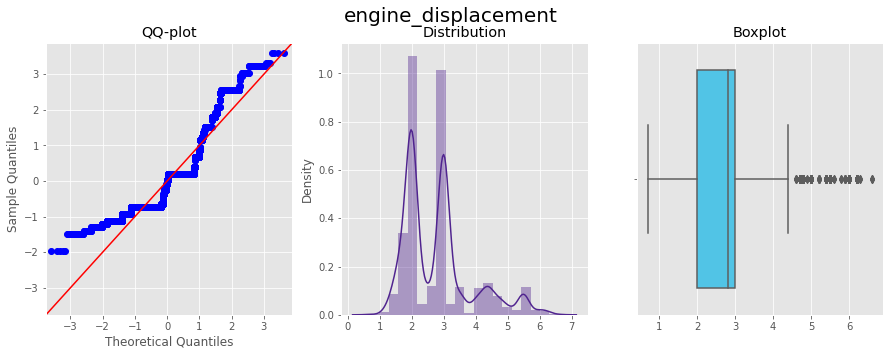

Outlier for engine_displacement is {'lower_bound': 0.5, 'upper_bound': 4.5, 'outlier_count': 565}


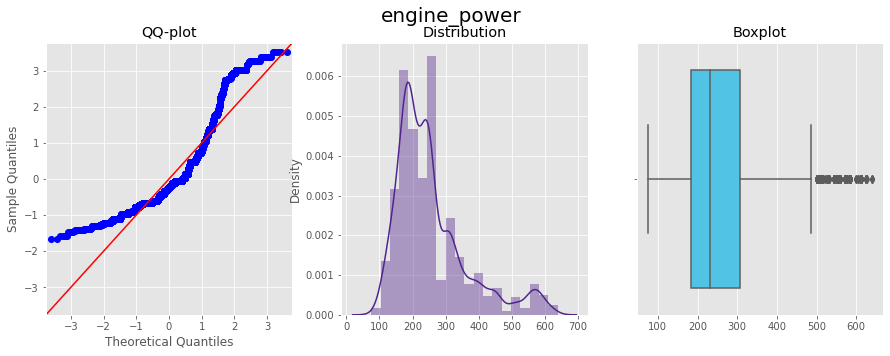

Outlier for engine_power is {'lower_bound': 1.0, 'upper_bound': 489.0, 'outlier_count': 402}


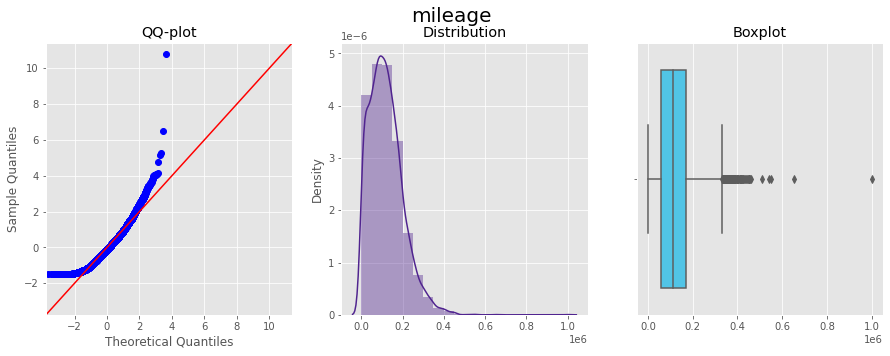

Outlier for mileage is {'lower_bound': -104046.875, 'upper_bound': 331228.125, 'outlier_count': 113}


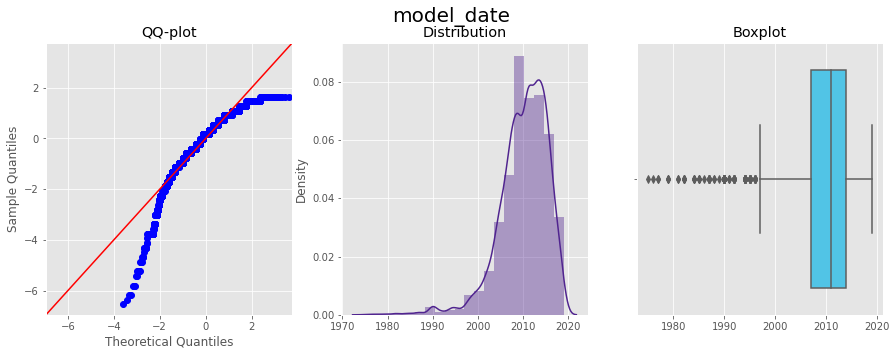

Outlier for model_date is {'lower_bound': 1996.5, 'upper_bound': 2024.5, 'outlier_count': 143}


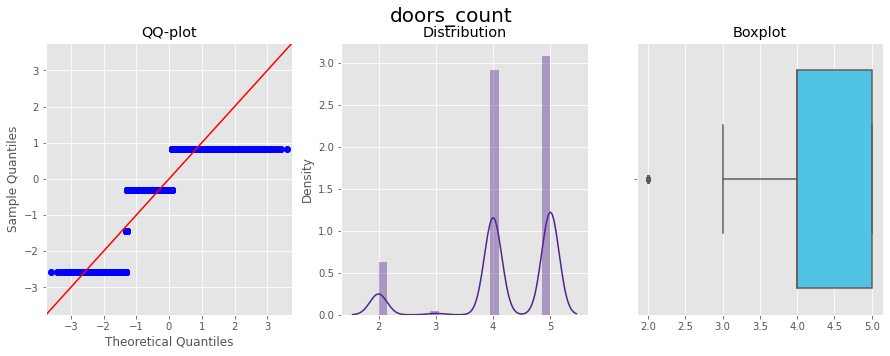

Outlier for doors_count is {'lower_bound': 2.5, 'upper_bound': 6.5, 'outlier_count': 627}


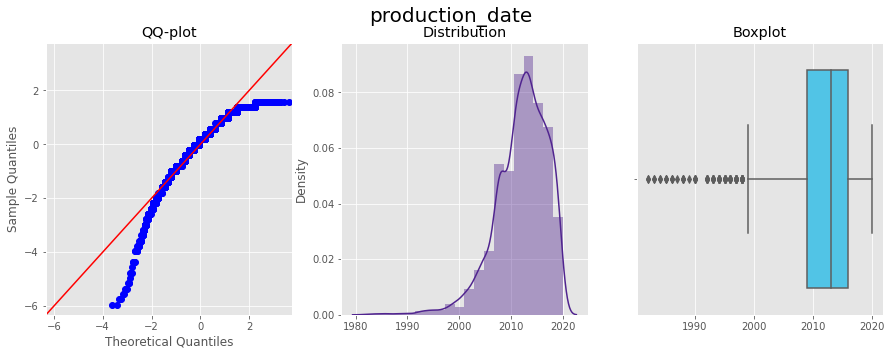

Outlier for production_date is {'lower_bound': 1998.5, 'upper_bound': 2026.5, 'outlier_count': 106}


In [62]:
for col in num_cols:
    get_variable_distribution(df_train[col], title=col)
    outl = outlier.get_IQR_outliers(col)
    print(f'Outlier for {col} is {outl}')

All our numeric data has outliers (By IQR method of identifying). However, we need to discover whetere they are outliers indeed?

With a reference to a QQ-plot,unfortunatelly, we have no a normal distribution. But it is close to it.

Doors count can be converted to category

Mileage column has lots of cars with zero. It is not logical. Even new car must have some kilometers.

Probably we need to apply logarithm function to fix this problem.

Also, the data need to be scaled. We will try to use Robust Scaler as it is more stable with outliers in data set

<a id="sec8.5"></a>
## [8.5 Correlation matrices](#sec8.5)
[(INDEX)](#sec2)

Let's check correlation matrix for categorical data first

Before we do, we need to fill up missing values and encode categorical data

In [63]:
# Create an instance of our encoder classs
encoder = Encoder(df_train)

In [64]:
cat_cols = ['body_type','brand',
            'color','fuel_type',
            'vehicle_transmission',
            'owner_count',
            'car_passport','wheel_drive',
            'wheel_location','model_info'
           ]

In [65]:
# fill missing vals and encode in loop
for col in cat_cols:
    missing_vars(df_train,col)
    encoder.label_encoder(col)

Rank of Matrix: 10
Determinant of matrix: 0.2566
Shape of matrix: (10, 10)


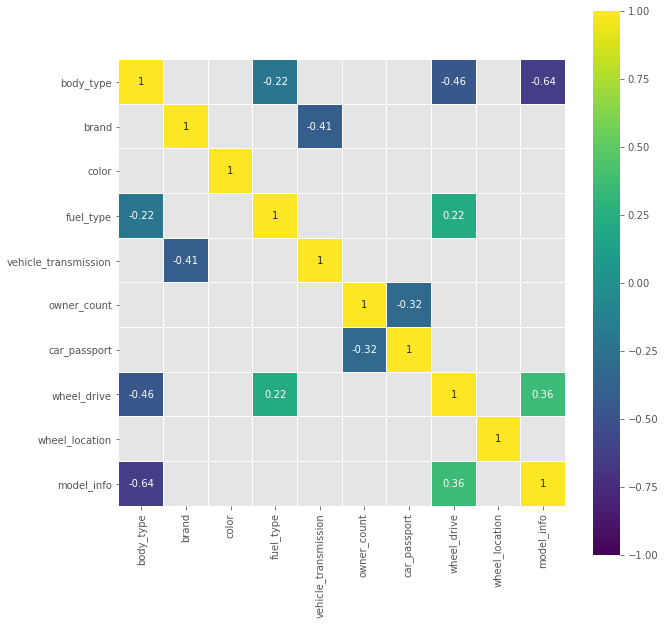

In [66]:
# call function to build corr matrrix
corr_matrix(df_train[cat_cols],det=True)

We have quite strong correlation between model_info and body type (-0.64) and less correlated fuel_type and wheel_drive.

vehicle_transmission correlated with brand.

It is full rank matrix and its determinant bigger than zero.

Seems nothing critical here. We will keep it as it is.

Rank of Matrix: 6
Determinant of matrix: 0.0056
Shape of matrix: (6, 6)


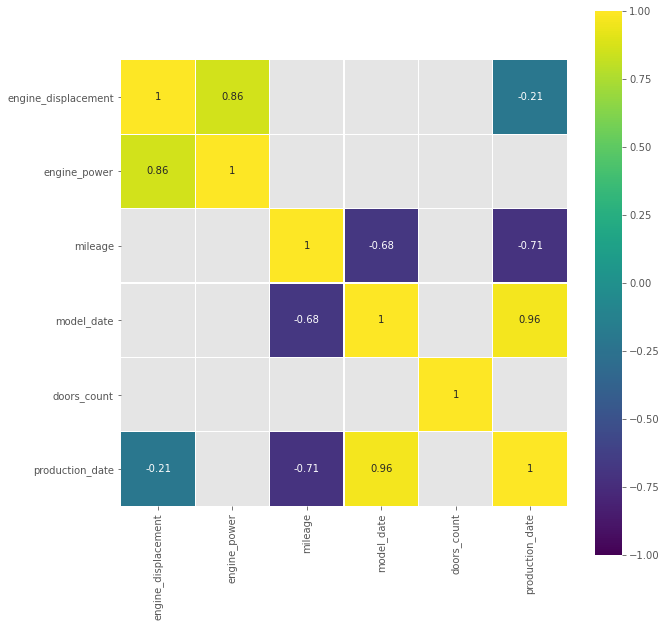

In [67]:
# call function to build corr matrrix
corr_matrix(df_train[num_cols])

Model date and production date almost fully correlated. Need to drop one of the column or apply PCA.

Engine power correlated with engine_disaplacement

Mileage and production date strongly correlated. Old car - bigger mileage.

It is a full rank matrix, but determinant is close to 0. We may have a problems if use all features

<a id="sec8.6"></a>
## [8.6 Sentiment Analyse](#sec8.6)
[(INDEX)](#sec2)

In [68]:
df_sentiment = df_train[['description','price']]
df_sentiment['description'] = df_sentiment['description'].fillna('none')
df_sentiment['description'] = df_sentiment['description'].apply(cleanTxt)

In [69]:
# Create a function to get the subjectivity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [70]:
# Create new cols and call the func

df_sentiment['subjectivity'] = df_sentiment['description'].apply(
    get_subjectivity)


df_sentiment['polarity'] = df_sentiment['description'].apply(get_polarity)

# show data
df_sentiment.sample(4)

description      price  \
1355  выгода до 82 000 руб при обмене на ваш автомоб...  2375000.0   
376   поменял очень многое вложил больше двух сот ты...   700000.0   
3304  продаю срочно авто в отличном состоянии без на...  1350000.0   
5288  я второй владелец авто куплен автомобиль при п...   850000.0   

      subjectivity  polarity  
1355           0.0       0.0  
376            0.0       0.0  
3304           0.0       0.0  
5288           0.0       0.0

In [71]:
df_sentiment['description'] = df_sentiment['description'].apply(
    lambda x: x.lower())

In [72]:
import nltk

In [73]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


False

In [74]:
stopword = set(stopwords.words('russian'))

newStopWords = set(['автомобиль','авто',  'продаю', 'автомобилей', 
                    'пробег','пробегом','автомобилей','машина'])

In [75]:
stopword.update(newStopWords)

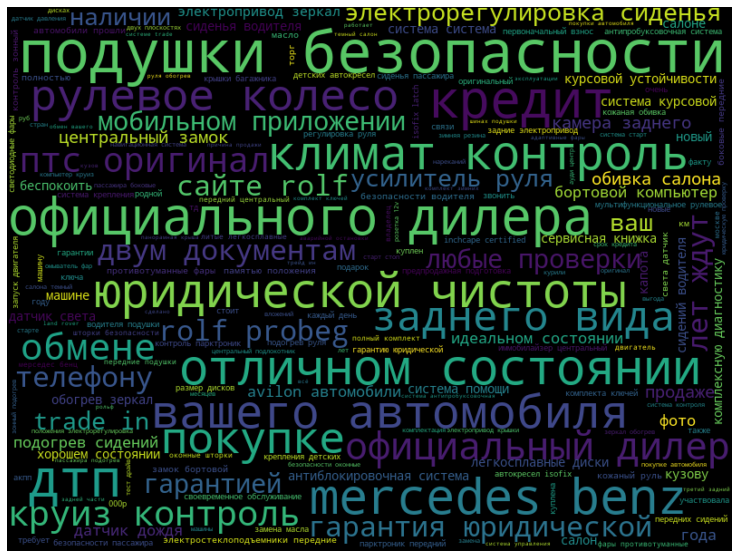

In [76]:
# Plot Word Cloud
all_words = ' '.join([
    description for description in df_sentiment['description']
    if description != 'none'
])

wordCloud = WordCloud(
                      stopwords=stopword,
                      width=800,
                      height=600,
                      random_state=42,
                      max_font_size=119).generate(all_words)

plt.figure(figsize=(15, 10))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

People think that the mention of airbags is a sales success while it is obligatory thing in a car.

Mentioning of safety of a driver dominating above other words.

Probably this information will help us in the model computing.

In [77]:
# Create a function to compute the negative, neutral and positive analysis
def get_analysis(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

In [78]:
df_sentiment['analysis'] = df_sentiment['polarity'].apply(get_analysis)

In [79]:
# Check positive and negative words in percents
df_sentiment['analysis'].value_counts(normalize=True)*100

neutral     88.057468
positive     8.365759
negative     3.576773
Name: analysis, dtype: float64

We can see that most descriptions has neutral polarity.

Most likely, this information is useless for the model for the reason of lack of diversity in positive/negative descriptions. But it indeed to be checked.

<a id="sec8.7"></a>
## [8.7 Draw a Conclusion](#sec8.7)
[(INDEX)](#sec2)

***Target*** variable has outliers.

***Target*** variable has missing values.

***body types*** count can be reduced and use top 5 most common.

***engine_displacement*** - the overwhelming majority of engines has a volume of 2 liters. Right after it comes the engine with 1.6 liters. Has missing vals.

***mileage*** - Significant amount of cars with zero mileage (probably new cars). Has zero values

***model_name*** Has more models than in test set, however, train set does not include some models which presented in ttest set 

***model_date*** - Data set includes really old cars (minimu model day is 1908).

***owning_period*** - most of data in this column is missed

***Price*** of electric cars in average higher than price for cars with conventional engine type.

***Engine displacement*** for electric cars is equal to zero.

Bigger ***displacement*** - more ***power***.

More ***power*** - ***expensive***

Old car - more owners. Check which feature impact on a prediction. ***Owner count*** or ***production year***.

***The production date*** and ***milage negativelly*** impact on a ***price***. More older car with hige mileage has lower price.

***Model and mileage*** are strongly correlated with ***production date***.

We have some features which is slightly ***correlated*** with ***target*** variable.

Mentioning of ***safety*** of a driver dominating above other words

Doors count convert to category

<a id="sec9"></a>
# [9. Feature Engeneering](#sec9)
[(INDEX)](#sec2)

Get lowercase for all columns with object type

In [80]:
# take cols with objects
object_columns = df.dtypes[df.dtypes.values == object].index.to_list()

for col in object_columns:
    df[col] = df[col].apply(lambda string: get_low_registr(string))

**[Target]**

As our dataset includes combined train & test sets, let's extract only train part for a minute and process it

In [81]:
# Defining features and target
X_train = df[df['sample'] == 1]

X_test = df[df['sample'] == 0]

With a reference to EDA, we remember that target is not normally distributed.

Let's apply logarithm to it and see what will happen

In [82]:
X_train['price']= np.log(X_train['price'])

Text(0.5, 0, 'Price')

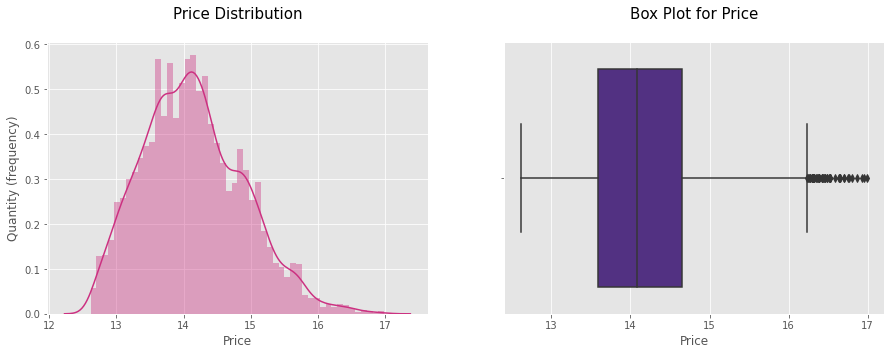

In [83]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(X_train.price.values, bins=50, color=colors[4])
plt.title('Price Distribution\n', fontsize=15)
plt.xlabel('Price')
plt.ylabel('Quantity (frequency)')

plt.subplot(122)
sns.boxplot(X_train.price.values, color=colors[1])
plt.title('Box Plot for Price\n', fontsize=15)
plt.xlabel('Price')

Looks better. Let's again combine datasets for further engineering

In [84]:
# combine sets
df = X_train.append(X_test, sort=False).reset_index(drop=True)

**[body_type & Model_info]**

As we have quite a lot of brands in data set, and especially lot's of models in model_info,

let's generate new feature for each of mentioned model and brand by taking mean price of each model/brand

In [85]:
cols_to_process = ['model_info', 'brand', 'body_type']
for col in cols_to_process:
    col_mean_dict = df.groupby([col])['price'].mean().to_dict()
    df[f'priced_{col}'] = df[col].apply(lambda x: col_mean_dict[x])

Because the models is mismatching in train and test set, we will have some empty cells for some models after applying cell above.

Let's fix it by filling it with median

In [86]:
print(f' Missing cells  {df["priced_model_info"].isna().sum()}')

 Missing cells  5


In [87]:
df['priced_model_info'] = df['priced_model_info'].fillna(
    df['priced_model_info'].median())

Reduce quantity of body_types

In [88]:
print(f' Number of types before reducing:  {df.body_type.nunique()}')

 Number of types before reducing:  17


In [89]:
pattern = re.compile('[а-я]*')
new_column = []
for string in df['body_type']:
    new_column.append(pattern.match(str(string))[0])
df['body_type'] = new_column

In [90]:
print(f' Number of types after reducing:  {df.body_type.nunique()}')

 Number of types after reducing:  12


In [91]:
# Create list with top body types
top_bodies = df['body_type'].value_counts()[df['body_type'].value_counts(
) > np.percentile((df['body_type'].value_counts().values), 50)].index.tolist()

#take all bodies from df to a list
all_bodies = df['body_type'].value_counts().index

# Identify, what to delete
bodies_to_drop = set(all_bodies) - set(top_bodies)

# Make replacemewnt
df.loc[df['body_type'].isin(bodies_to_drop), 'body_type'] = 'other'

Translate it to english. (for some reason, LightGBM doesn't work with russian column names)

In [92]:
body_type_dict = dict({
    'седан':'sedan',
    'внедорожник':'4wd',
    'купе':'coupe',
    'хэтчбек':'hatchback',
    'other':'other',
    'лифтбек':'liftback',
    'универсал':'universal'
})
df['body_type'] = df['body_type'].map(body_type_dict)

In [93]:
df.body_type.unique()

array(['sedan', 'liftback', '4wd', 'hatchback', 'other', 'universal',
       'coupe'], dtype=object)

Fine, we reduced number of body_types and translated it in to English

**[Description]**

Let's generate new features:
- Sensitivity and polarity of each description in a column;
- Extract keywords from description

In [94]:
df['description'] = df['description'].fillna('none')
df['description'] = df['description'].apply(cleanTxt)
df['description'] = df['description'].apply(lambda x : x.lower())

In [95]:
# Create a function to get the subjectivity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity


# Create a function to get the polarity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [96]:
# Create new cols and call the func

df['subjectivity'] = df['description'].apply(get_subjectivity)

df['polarity'] = df['description'].apply(get_polarity)

With a reference to EDA (Sentiment section), let's check plot of worldcloud and generate new features. 

If description has specified keyword, the we add 1 to new column

In [97]:
df['airbags'] = df['description'].apply(
    lambda x: 1 if 'подушки безопасности' in x else 0)
df['cruise'] = df['description'].apply(
    lambda x: 1 if 'круиз' in x else 0)
df['steering'] = df['description'].apply(
    lambda x: 1 if 'усилитель руля' in x else 0)
df['loan'] = df['description'].apply(
    lambda x: 1 if 'кредит' in x else 0)
df['lock'] = df['description'].apply(
    lambda x: 1 if 'центральный замок' in x else 0)
df['climat'] = df['description'].apply(
    lambda x: 1 if 'климат контроль' in x else 0)

**[Fuel Type]**

In [98]:
fuel_type_dict = dict({
    'бензин':'gasoline',
    'дизель':'diesel',
    'гибрид':'hybrid',
    'электро':'electro',
})

df['fuel_type'] = df['fuel_type'].map(fuel_type_dict)

**[Engine Displacement]**

We know, that there is no engine displacement for the electrical cars. We also know there is missing values in this columns.

Let's fix it. If car is electric - displacement shall be 0.

In [99]:
def get_electro_displacement(engine_displacement, fuel_type):
    '''Filling mising vars for electrocars'''
    
    if fuel_type == 'electro':
        return 0
    else:
        return engine_displacement

In [100]:
df['engine_displacement'] = df[['engine_displacement','fuel_type']].apply(
    lambda x: get_electro_displacement(*x), axis=1)

There is a special low in Russian Federation that devide cars by tax categories.

More power in engine, higher grade of tax. It may impact on a prediction. Let's break our cars down by such categories

In [101]:
# Break engine power by intervals
bins = [10, 35, 100, 125, 150, 175, 200, 225, 250, 801]
# Ctreate tax categories
numbers = ['5000', '12', '25', '35', '45', '50', '65', '75', '150']

In [102]:
# Make a column where refer each car depended by power to a tax cat
df['tax_base'] = pd.cut(df['engine_power'], bins, labels=numbers)
df['tax_base'] = df['tax_base'].values.astype('int64')

In [103]:
# generate tax fee col
df['tax'] = df['engine_power'] * df['tax_base']

**[Wheel Drive]**

In [104]:
drive_type_dict = dict({
    'передний': 'front',
    'полный': 'full',
    'задний': 'rear',
})

df['wheel_drive'] = df['wheel_drive'].map(drive_type_dict)

**[Owner_count]**

In [105]:
cols_to_fill = ['owner_count',]
for col in cols_to_fill:
    missing_vars(df,col)

**[Handling multocorrelation out]**

In [106]:
# extract trhee columns from dataset, which are correlated
data = df[['engine_displacement', 'engine_power',]].values
# create Scaler instance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# We have 3 vectors. Reduce to two, taking most important info.
pca = PCA(n_components=1)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
df['pca_pwr_dsplc'] = pca_data[:, 0]

**[Log Func]**

In [107]:
cols_to_log = [
    'engine_displacement', 'mileage', 'model_date', 'production_date', 
    'tax', 'pca_pwr_dsplc','priced_model_info'
]

df = to_log(df, cols_to_log)

<a id="sec9.1"></a>
## [9.1 Encoding](#sec9.1)
[(INDEX)](#sec2)

In [108]:
# Re-set indexes
df.reset_index(drop=True, inplace=True)
encoder = Encoder(df)

In [109]:
to_hot = [
    'body_type', # No impact
    'brand', # No impact
    'color', # No impact
    'fuel_type',   # No impact
    'doors_count', # No impact
    'vehicle_transmission', # No impact
    'wheel_drive',
    'owner_count',
]

to_label = [
    'car_passport', 'wheel_location'
]

In [110]:
# hot it out
for col in to_hot:
    df = encoder.hot_encoder(col)

In [111]:
# label it
for col in to_label:
    encoder.label_encoder(col)

**[Dropping columns out]**

In [112]:
df_1 = df.copy()

In [113]:
cols_to_drop = [
    'description',
    'engine_power',
    'sell_id',
    'model_info',
    'name',
    'vehicle_configuration',
    'owning_period',
]
df = df.drop(cols_to_drop, axis=1)

<a id="sec9.2"></a>
## [9.2. Prepare the data for models](#sec9.2)
[(INDEX)](#sec2)


In [114]:
# Defining features and target
X = df[df['sample'] == 1].drop(['price','sample'], axis=1)
y = df[df['sample'] == 1]['price']

X_test = df[df['sample'] == 0].drop(['price','sample'], axis=1)

In [115]:
cols_to_scal = [
    'engine_displacement','mileage', 'subjectivity', 
    'polarity', 
    'pca_pwr_dsplc',
    'priced_model_info','priced_brand','priced_body_type','tax'
]

In [116]:
scaler = RobustScaler()
X[cols_to_scal] = scaler.fit_transform(X[cols_to_scal])
X_test[cols_to_scal] = scaler.transform(X_test[cols_to_scal])

In [117]:
# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.15,
                                                  shuffle=True,
                                                  random_state=42)

print(
    f'Train size: {X_train.shape}, Validation size: {X_val.shape}, Test size: {X_test.shape}'
)

Train size: (5679, 64), Validation size: (1003, 64), Test size: (1671, 64)


<a id="sec10"></a>
# [10. Models](#sec10)
[(INDEX)](#sec2)

<a id="sec10.1"></a>
## [10.1. CatBoost Regressor](#sec10.1)
[(INDEX)](#sec2)

In [118]:
cbr = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
cbr.fit(X_train, y_train,
         eval_set=(X_val, y_val),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.0418667	test: 0.0419150	best: 0.0419150 (0)	total: 159ms	remaining: 13m 15s
100:	learn: 0.0122774	test: 0.0119208	best: 0.0119208 (100)	total: 336ms	remaining: 16.3s
200:	learn: 0.0098646	test: 0.0097433	best: 0.0097433 (200)	total: 503ms	remaining: 12s
300:	learn: 0.0092213	test: 0.0092805	best: 0.0092805 (300)	total: 674ms	remaining: 10.5s
400:	learn: 0.0088409	test: 0.0090038	best: 0.0090038 (400)	total: 842ms	remaining: 9.66s
500:	learn: 0.0085518	test: 0.0087715	best: 0.0087715 (500)	total: 1.01s	remaining: 9.11s
600:	learn: 0.0082318	test: 0.0085392	best: 0.0085392 (600)	total: 1.18s	remaining: 8.66s
700:	learn: 0.0080011	test: 0.0083970	best: 0.0083964 (699)	total: 1.35s	remaining: 8.28s
800:	learn: 0.0077869	test: 0.0082823	best: 0.0082823 (799)	total: 1.52s	remaining: 7.95s
900:	learn: 0.0075963	test: 0.0081811	best: 0.0081811 (900)	total: 1.69s	remaining: 7.67s
1000:	learn: 0.0074089	test: 0.0081014	best: 0.0081014 (1000)	total: 1.85s

In [119]:
cbr_pred = cbr.predict(X_val)

In [120]:
df_report = get_regression_metrics(df_report,y_val,cbr_pred, 'CatBoost')
df_report

MAPE            MAE           MSE           RMSE
BaseLine  19.877351  347328.243270  8.691772e+11  932296.757864
CatBoost  11.025934  206315.415429  2.542889e+11  504270.700667

It is definitely better than the baseline. We have dropped almost 9% of error

In [121]:
# sub_predict_catboost = cbr.predict(X_test)
# sample_submission['price'] = sub_predict_catboost
# sample_submission.to_csv('catboost_submission.csv', index=False)

<a id="sec10.2"></a>
## [10.2. LightGBM + OPTUNA](#sec10.2)
[(INDEX)](#sec2)

In [122]:
# Defining MAPE function since it was removed from sklearn
# Use only for optuna
def mape_11(y_pred,y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [123]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'metric': 'mape', 
        'random_state': 42,
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100,500,700]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = lgb.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    mape = mape_11(np.expm1(test_y), np.expm1(preds))
    
    return mape

In [124]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2021-07-11 08:55:51,926] A new study created in memory with name: no-name-26347ee9-91b1-4dca-a4b8-6ba6f16e630d
[W 2021-07-11 08:55:51,946] Trial 0 failed because of the following error: LightGBMError('Do not support non-ASCII characters in feature name.')
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\optuna\_optimize.py", line 217, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-123-2401e46b6dad>", line 20, in objective
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 734, in fit
    super(LGBMRegressor, self).fit(X, y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 594, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(para

LightGBMError: Do not support non-ASCII characters in feature name.

In [ ]:
# Take best parameters
param_lgb = study.best_params

In [ ]:
# Fit model
lgb_opt = lgb.LGBMRegressor(**param_lgb)
lgb_opt.fit(X_train, y_train,)

In [ ]:
#Make a predictions
lgb_opt_pred = lgb_opt.predict(X_val)

In [ ]:
df_report = get_regression_metrics(df_report,y_val,lgb_opt_pred, 'LGB+optuna')
df_report

No significant improvement of the metric. 

We need to call heavy artillery.

In [ ]:
# Check permutation
lightgbm.plot_importance(lgb_opt, ax=None, height=0.2, xlim=None, ylim=None,
                         title='Feature importance', xlabel='Feature importance', 
                         ylabel='Features', importance_type='split', max_num_features=None,
                         ignore_zero=True, figsize=(10,10), dpi=None, grid=True, precision=3);

We can see that some columns have no impact to model. LAter we can delete them

In [ ]:
hjkg

<a id="sec10.3"></a>
## [10.3. Tabular NN](#sec10.3)
[(INDEX)](#sec2)

In [150]:
input_ = Input(shape=X_train.shape[1])
output = Sequential([
    Dense(1000, 'relu'),
    Dropout(0.5),
    Dense(1000, 'relu'),
    Dropout(0.5),
    Dense(1)
])(input_) + Dense(1, kernel_initializer='zeros')(input_)

model = Model(inputs = input_,outputs = output)

In [151]:
scaler = StandardScaler().fit(X_train)
X_train_for_NN = np.clip(scaler.transform(X_train), -5, 5)
X_val_for_NN = np.clip(scaler.transform(X_val), -5, 5)

Create a model, where in each iteration we gradually reduce the learning rate

In [152]:
model.compile(loss='mse', optimizer=Adam(1e-2))
progress_bar = tqdm(total=1000)
history = model.fit(
    X_train_for_NN,
    y_train,
    validation_data=(X_val_for_NN, y_val),
    batch_size=100,
    epochs=1000,
    verbose=0,
    callbacks=[
        EarlyStopping(patience=200, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(patience=100, verbose=1),
        LambdaCallback(on_epoch_end=lambda epoch, logs: progress_bar.update(1))
    ])


  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 00203: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00387: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Restoring model weights from the end of the best epoch.

Epoch 00487: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00487: early stopping


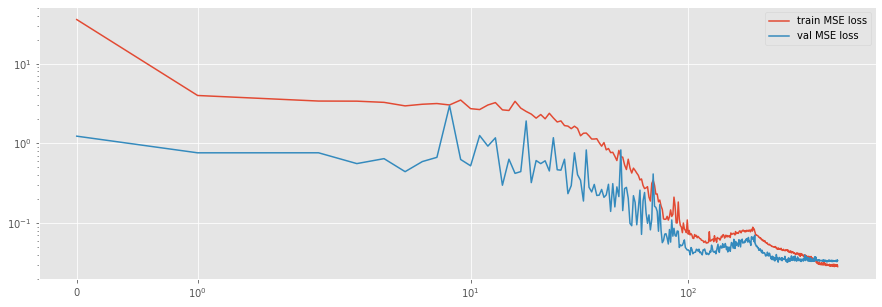

In [153]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='train MSE loss')
plt.plot(history.history['val_loss'], label='val MSE loss')
plt.legend()
plt.gca().set_xscale('symlog')
plt.gca().set_yscale('log')
plt.show()

The model is overfitted a bit. 

In [154]:
df_report = get_regression_metrics(df_report, y_train,
                                   model.predict(X_train_for_NN)[:, 0],
                                   'NN_Train')

In [155]:
df_report = get_regression_metrics(df_report, y_val,
                                   model.predict(X_val_for_NN)[:, 0],
                                   'NN_Test')
df_report

MAPE            MAE           MSE           RMSE
BaseLine  19.877351  347328.243270  8.691772e+11  932296.757864
CatBoost  11.025934  206315.415429  2.542889e+11  504270.700667
NN_Train  11.138654  232593.918928  3.981387e+11  630982.304385
NN_Test   13.229451  271588.774302  4.483335e+11  669577.130252

Well, it shows not bad results but yet not better than conventional ML models.

We have applied clipping of data -5 +5 for cut big or small values in the features. 

In the next section we will try ti use NLP models as an additional layer.

Perhaps it might improve the score a little bit

<a id="sec10.4"></a>
## [10.3. Multiple NN](#sec10.4)
[(INDEX)](#sec2)

In [156]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

Before we do, let's preprocess the text a little bit

Apply lemmatiztion and apply stopwords

In the code above we have saved unscalled but preprocessed data frame with all columns.

Let's take *description* column from it and work on it

In [128]:
def get_lemma(text):
    '''Function is called for lemmatize text'''
    mystem = Mystem()
    stopword = set(stopwords.words('russian'))
    trash = set(['• ','%','-'])
    text = mystem.lemmatize(text.lower())
    clean_text = [w for w in text if len(w.strip())]
    cl_txt = []
    for word in clean_text:
        if word not in stopword and word not in trash:
            cl_txt.append(word)

    return cl_txt

In [129]:
#%%script False
df_1['description_lemm'] = df_1['description'].apply(get_lemma)

In [131]:
#%script False
# Save to csv. Save time while running
df_1.to_csv('df_preproc.csv', index = False)

In [132]:
df_lem = pd.read_csv('df_preproc.csv')

In [136]:
%%script False
# extract the data
text_train = df_lem['description'].iloc[X_train.index]
text_val = df_lem['description'].iloc[X_val.index]
text_test = df_lem['description'].iloc[X_test.index]

In [157]:
#%%script False
# extract the data
text_train = df_lem['description_lemm'].iloc[X_train.index]
text_val = df_lem['description_lemm'].iloc[X_val.index]
text_test = df_lem['description_lemm'].iloc[X_test.index]

In [158]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(df_lem.description_lemm)

Wall time: 1.06 s


In [159]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_val_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_val), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_val_sequences.shape, text_test_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
Wall time: 911 ms


In [145]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

['автомобиль', 'проверять', '110', 'пункт', 'автокредит', 'специальный', 'ставка', '137', 'ауди', 'центр', 'север', 'официальный', 'дилер', 'audi', 'входить', 'группа', 'компания', 'рольф', 'являться', 'крупный', 'дилер', 'европа', 'предлагать', 'ряд', 'услуга', 'покупка', 'продажа', 'автомобиль', 'пробегомна', 'протяжение', 'многий', 'год', 'наш', 'дилерский', 'центр', 'являться', 'лидер', 'продажа', 'автомобиль', 'пробег', 'среди', 'весь', 'дилер', 'audi', 'россия', 'предоставлять', 'клиент', 'самый', 'большой', 'выбор', 'автомобиль', 'пробег', 'audi', 'мароккаждый', 'автомобиль', 'проходить', 'тщательный', 'диагностика', 'подготовка', 'гарантировать', 'находиться', 'отличный', 'состояниичтоба', 'убеждаться', 'правильный', 'выбор', 'возможность', 'проходить', 'тест-драйв', ' ― ', 'ознакомительный', 'поездка', 'интересовать', 'автомобилевый', 'смочь', 'ознакомляться', 'автомобиль', 'выходить', 'дом', ' – ', 'наш', 'менеджер', 'проводить', 'online', 'презентация', 'видеозвонок', 'показ

In [161]:
input_nlp = Input(shape=MAX_SEQUENCE_LENGTH,name="seq_description")
output_nlp = Sequential([
    Embedding(len(tokenize.word_index)+1,MAX_SEQUENCE_LENGTH),
    LSTM(256, return_sequences=True),
    Dropout(0.5),
    LSTM(128),
    Dropout(0.25),
    Dense(64, activation="relu"),
    Dropout(0.25)    
])(input_nlp) + Dense(1, kernel_initializer='zeros')(input_nlp)

model_nlp = Model(inputs = input_nlp,outputs = output_nlp)

In [162]:
input_ = Input(shape=X_train.shape[1])
output = Sequential([
    Dense(1000, 'relu'),
    Dropout(0.5),
    Dense(1000, 'relu'),
    Dropout(0.5),
    Dense(1)
])(input_) + Dense(1, kernel_initializer='zeros')(input_)

model_mlp = Model(inputs = input_,outputs = output)

In [163]:
combinedInput = concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = Dense(64, activation="relu")(combinedInput)
head = Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [145]:
# optimizer = tf.keras.optimizers.Adam(0.01)
# model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [146]:
# checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
# earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
# callbacks_list = [checkpoint, earlystop]

In [147]:
# history = model.fit([text_train_sequences, X_train_for_NN], y_train,
#                     batch_size=512,
#                     epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
#                     validation_data=([text_test_sequences, X_test], y_test),
#                     callbacks=callbacks_list,
#                     verbose=0
#                    )

In [164]:
model.compile(loss='mse', optimizer=Adam(0.1))
progress_bar = tqdm(total=1000)
history = model.fit(
    [text_train_sequences, X_train_for_NN],
    y_train,
    validation_data=([text_val_sequences, X_val_for_NN], y_val),
    batch_size=512,
    epochs=1000,
    verbose=0,
    callbacks=[
        EarlyStopping(patience=200, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(patience=100, verbose=1),
        LambdaCallback(on_epoch_end=lambda epoch, logs: progress_bar.update(1))
    ])


  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 00133: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Restoring model weights from the end of the best epoch.

Epoch 00233: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 00233: early stopping


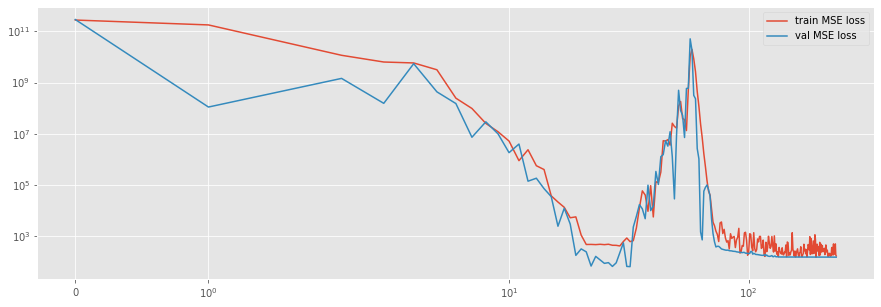

In [165]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='train MSE loss')
plt.plot(history.history['val_loss'], label='val MSE loss')
plt.legend()
plt.gca().set_xscale('symlog')
plt.gca().set_yscale('log')
plt.show()

In [166]:
df_report = get_regression_metrics(df_report, y_train,
                                   model.predict([text_train_sequences, X_train_for_NN])[:, 0],
                                   'NN+NLP_Train')

In [167]:
df_report = get_regression_metrics(df_report, y_val,
                                   model.predict([text_val_sequences, X_val_for_NN])[:, 0],
                                   'NN+NLP_Test')
df_report

MAPE           MAE           MSE          RMSE
BaseLine      1.987735e+01  3.473282e+05  8.691772e+11  9.322968e+05
CatBoost      1.102593e+01  2.063154e+05  2.542889e+11  5.042707e+05
NN_Train      1.113865e+01  2.325939e+05  3.981387e+11  6.309823e+05
NN_Test       1.322945e+01  2.715888e+05  4.483335e+11  6.695771e+05
NN+NLP_Train  3.141268e+25  1.663527e+29  1.043938e+62  1.021733e+31
NN+NLP_Test   1.461301e+12  1.673841e+16  1.948094e+35  4.413721e+17

In [ ]:
cccb

<a id="sec10.5"></a>
## [10.3. Add some images](#sec10.5)
[(INDEX)](#sec2)

In [ ]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = df_train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(df_1['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

In [ ]:
images_train = get_image_array(X_train.index)
images_val = get_image_array(X_val.index)
images_test = get_image_array(X_test.index)

**[albumentations]**

In [ ]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[10])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
def make_augmentations(images):
    print('применение аугментаций', end='')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end='')
        augment_dict = augmentation(image=images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [ ]:
def process_image(image):
    return augmentation(image=image.numpy())['image']


def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions),
                                  maxlen=MAX_SEQUENCE_LENGTH)


def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]


def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [
        image,
    ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [
        text,
    ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


def tf_process_val_dataset_element(image, table_data, text, price):
    [
        text,
    ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


train_dataset = tf.data.Dataset.from_tensor_slices(
    (images_train, X_train, df_1.description.iloc[X_train.index],
     y_train)).map(tf_process_train_dataset_element)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (images_val, X_val, df_1.description.iloc[X_val.index],
     y_val)).map(tf_process_val_dataset_element)

y_test = np.zeros(len(X_test))
test_dataset = tf.data.Dataset.from_tensor_slices(
    (images_test, X_test, df_1.description.iloc[X_test.index],
     y_test)).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__()
val_dataset.__iter__().__next__()
test_dataset.__iter__().__next__()

In [ ]:
import tensorflow.keras.layers as L

In [ ]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [ ]:
# Create tabular NN (again)
input_ = Input(shape=X_train.shape[1])
output = Sequential([
    Dense(1000, 'relu'),
    Dropout(0.5),
    Dense(1000, 'relu'),
    Dropout(0.5),
    Dense(1)
])(input_) + Dense(1, kernel_initializer='zeros')(input_)

model_tab = Model(inputs = input_,outputs = output)

In [ ]:
input_nlp = Input(shape=MAX_SEQUENCE_LENGTH,name="seq_description")
output_nlp = Sequential([
    Embedding(len(tokenize.word_index)+1,MAX_SEQUENCE_LENGTH),
    LSTM(256, return_sequences=True),
    Dropout(0.5),
    LSTM(128),
    Dropout(0.25),
    Dense(64, activation="relu"),
    Dropout(0.25)    
])(input_nlp) + Dense(1, kernel_initializer='zeros')(input_nlp)

model_nlp = Model(inputs = input_nlp,outputs = output_nlp)

In [ ]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, model_tab.output, model_nlp.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, model_tab.input, model_nlp.input], outputs=head)
model.summary()

In [ ]:
model.compile(loss='mse', optimizer=Adam(1e-2))
progress_bar = tqdm(total=1000)
history = model.fit(
    train_dataset.batch(30),
    validation_data=(val_dataset.batch(30)),
   # batch_size=100,
    epochs=100,
    verbose=0,
    callbacks=[
        EarlyStopping(patience=100, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(patience=50, verbose=1),
        LambdaCallback(on_epoch_end=lambda epoch, logs: progress_bar.update(1))
    ])
